gpt 모델 아키텍처

- 목적 : 한글 영어 번역

In [1]:
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm, tqdm_notebook, trange

from tensorflow.keras.layers import Dense , Input 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model 


In [2]:
tf.__version__

'2.13.0'

In [3]:
tf.random.set_seed(42)
AUTO = tf.data.experimental.AUTOTUNE

In [4]:
# 모델 훈련 파라미터 값
ENCODER_LEN = 61
DECODER_LEN = ENCODER_LEN
BATCH_SIZE = 256
BUFFER_SIZE = 20000

N_EPRCHS = 20

In [5]:
# 훈련 데이터셋 로딩 
import urllib3
import zipfile
import shutil
import pandas as pd

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
http = urllib3.PoolManager()
url = "https://raw.githubusercontent.com/Huffon/pytorch-transformer-kor-eng/master/data/corpus.csv"
filename = './data/corpus.csv'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content = False ) as r , open(zipfilename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

In [8]:
total_df = pd.read_csv('./data/corpus.csv')

total_df.rename(columns={"english":'SRC', "korean":'TRG'}, inplace=True)

In [9]:
total_df['src_len'] = ""
total_df['tar_len'] = ""
total_df.head()

,TRG,SRC,src_len,tar_len
0,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.,,
1,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here.",,
2,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.,,
3,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.,,
4,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.,,


In [10]:
# 공백으로 구분해서 사용
for idx in range(len(total_df)) :
    text_eng = str(total_df.iloc[idx]['SRC'])

    result_eng = len(text_eng.split())
    total_df.at[idx, 'src_len'] = result_eng

    text_fra = str(total_df.iloc[idx]['TRG'])
    result_fra = len(text_fra.split())
    total_df.at[idx, 'tar_len'] = result_fra

In [11]:
total_df.head()

,TRG,SRC,src_len,tar_len
0,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.,10,7
1,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here.",7,5
2,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.,8,6
3,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.,8,6
4,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.,10,4


In [12]:
print(len(total_df))

115000


In [13]:
total_df = total_df.drop_duplicates(subset=["SRC"])
print(len(total_df))

99006


In [14]:
total_df = total_df.drop_duplicates(subset=["TRG"])
print(len(total_df))

95453


In [15]:
is_within_len = (7 < total_df['src_len']) & (total_df['tar_len'] <= 20) &  (7 < total_df['tar_len']) & (total_df['src_len'] <= 20)

In [16]:
total_df = total_df[is_within_len]
len(total_df)

21132

In [17]:
train_data = total_df.sample(n=1024*8 , random_state=42)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8192 entries, 38672 to 7829
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TRG      8192 non-null   object
 1   SRC      8192 non-null   object
 2   src_len  8192 non-null   object
 3   tar_len  8192 non-null   object
dtypes: object(4)
memory usage: 320.0+ KB


In [18]:
train_data.isnull().sum()

TRG        0
SRC        0
src_len    0
tar_len    0
dtype: int64

In [19]:
raw_src = []

for sentence in train_data['SRC'] :
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", " \1" , sentence)
    sentence = re.sub(r"[' ']+" , " " , sentence)
    sentence = re.sub(r"i'm", 'i am', sentence)
    sentence = re.sub(r"he's", 'he is', sentence)
    sentence = re.sub(r"she's", 'she is', sentence)
    sentence = re.sub(r"it's", 'it is', sentence)
    sentence = re.sub(r"that's", 'that is', sentence)
    sentence = re.sub(r"what's", 'what is', sentence)
    sentence = re.sub(r"where's", 'where is', sentence)
    sentence = re.sub(r"how's", 'how is', sentence)
    sentence = re.sub(r"\'ll", 'will', sentence)
    sentence = re.sub(r"\'ve", 'have', sentence)
    sentence = re.sub(r"\'re", 'are', sentence)
    sentence = re.sub(r"\'d", 'would', sentence)
    sentence = re.sub(r"won't", 'will not', sentence)
    sentence = re.sub(r"can't", 'cannot', sentence)
    sentence = re.sub(r"n't", 'not', sentence)
    sentence = re.sub(r"n'", 'ng', sentence)

    sentence = re.sub(r"[^a-z]+" , ' ', sentence)
    sentence = sentence.strip()
    raw_src.append(sentence)



In [20]:
raw_trg = []
for sentence in train_data['TRG'] :
    sentence = re.sub(r"[?.!,]", " \1" , sentence)
    sentence = sentence.strip()
    raw_trg.append(sentence)

In [21]:
len(raw_trg)

8192

In [22]:
print(raw_trg[:5])
print(raw_src[:5])

['또한 좋은 의상을 만들고자하는 그녀의 노력에 감명을 받았어요 \x01', '저는 상대방을 대할 때 항상 배려해주려 노력하고 솔직하게 대해요 \x01', '그렇군요 \x01 한국전자에서 요청한 변경 사항은 범위가 얼마나 돼요 \x01', '공원 안에서 자전거를 빌릴 수 있는 곳이 있나요 \x01', '페루라니 엄청나게 먼 나라인데 \x01 그곳에서 사람들이 케이팝을 듣는다고 \x01']
['i m also impressed by her efforts to make good costumes', 'i always try to treat others in thoughtful and truthful ways', 'i see what is the range of modification requested by korea electronics', 'is there a place in the park where i can rent bikes', 'peru is a country so far away people listen to k pop there']


In [23]:
df1 = pd.DataFrame(raw_src)
df2 = pd.DataFrame(raw_trg)

In [24]:
df1.rename(columns={0:"SRC"}, inplace=True)
df2.rename(columns={0:"TRG"}, inplace=True)
train_df = pd.concat([df1, df2], axis=1)

In [25]:
raw_src = train_df['SRC']
raw_trg = train_df['TRG']

In [26]:
# 토큰 적용을 위한 전처리 부분
special_tkns = "<PAD> <SOS> <EOS> <CLS> <SEP> <MASK> "
src_sentence = raw_src.apply(lambda x : "<CLS> " + str(x) + "<SEP>")
trg_sentence = raw_trg.apply(lambda x : str(x) + "<SEP>")

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

In [27]:
# 토크나이저 정의
SRC_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
TRG_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

SRC_tokenizer.fit_on_texts(special_tkns + src_sentence)
TRG_tokenizer.fit_on_texts(special_tkns + trg_sentence)

n_enc_vocab = len(SRC_tokenizer.word_index) + 7
n_dec_vocab = len(TRG_tokenizer.word_index) + 6 

In [28]:
n_enc_vocab , n_dec_vocab

(8600, 21395)

In [29]:
lines = [
    "It is winter and the weather is very cold.",
    "Will this Christmas be a white Christmas?",
    "Be careful not to catch a cold in winter"
]

In [30]:
for line in lines :
    txt_2_ids = SRC_tokenizer.texts_to_sequences([line])
    ids_2_txt = SRC_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input      :", line)
    print("txt_2_ids  :", txt_2_ids)
    print("ids_2_txt  :", ids_2_txt[0], "\n")

Input      : It is winter and the weather is very cold.
txt_2_ids  : [[13, 14, 894, 15, 9, 1113, 14, 115, 716]]
ids_2_txt  : it is winter and the weather is very cold 

Input      : Will this Christmas be a white Christmas?
txt_2_ids  : [[29, 26, 1492, 27, 12, 705, 1492]]
ids_2_txt  : will this christmas be a white christmas 

Input      : Be careful not to catch a cold in winter
txt_2_ids  : [[27, 1248, 40, 10, 890, 12, 716, 17, 894]]
ids_2_txt  : be careful not to catch a cold in winter 



In [31]:
lines = [
    "딥 러닝 자연어 처리에서 역시 전처리는 어려워요",
    "여러분들이 데이터 사이언티스트가 되어 현장에서 함께 하고 싶어요",
    "오늘은 즐거운 불금입니다."
]

In [32]:
for line in lines :
    txt_2_ids =  TRG_tokenizer.texts_to_sequences([line])
    ids_2_txt = TRG_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input      :", line)
    print("txt_2_ids  :", txt_2_ids)
    print("ids_2_txt  :", ids_2_txt[0], "\n")

Input      : 딥 러닝 자연어 처리에서 역시 전처리는 어려워요
txt_2_ids  : [[1, 1, 1, 1, 735, 1, 11034]]
ids_2_txt  : <unk> <unk> <unk> <unk> 역시 <unk> 어려워요 

Input      : 여러분들이 데이터 사이언티스트가 되어 현장에서 함께 하고 싶어요
txt_2_ids  : [[1, 17750, 1, 349, 13168, 71, 47, 123]]
ids_2_txt  : <unk> 데이터 <unk> 되어 현장에서 함께 하고 싶어요 

Input      : 오늘은 즐거운 불금입니다.
txt_2_ids  : [[263, 786, 1]]
ids_2_txt  : 오늘은 즐거운 <unk> 



In [33]:
# 텍스트 데이터의 길이를 맞춰주는 전처리
tokenized_inputs = SRC_tokenizer.texts_to_sequences(src_sentence)
tokenized_outputs = TRG_tokenizer.texts_to_sequences(trg_sentence)

pad_idx = SRC_tokenizer.texts_to_sequences(['<PAD>'])

tkn_sources = []
tkn_targets = []

for idx in range(len(tokenized_inputs)):
    indexed_src_tkns = tokenized_inputs[idx] + [0] * (ENCODER_LEN - len(tokenized_inputs[idx]))
    indexed_trg_tkns = [0] * len(tokenized_inputs[idx]) + tokenized_outputs[idx] + [0]*(ENCODER_LEN - len(tokenized_inputs[idx]) - len(tokenized_outputs[idx]))

    tkn_sources.append(indexed_src_tkns)
    tkn_targets.append(indexed_trg_tkns)

In [34]:
# list -> tf 
tensors_src = tf.cast(tkn_sources, dtype=tf.int64)
tensors_trg = tf.cast(tkn_targets, dtype=tf.int64)

In [35]:
tensors_src.shape , tensors_trg.shape

(TensorShape([8192, 61]), TensorShape([8192, 61]))

In [36]:
tensors_src[0]

<tf.Tensor: shape=(61,), dtype=int64, numpy=
array([   2,    8,   42,  107, 1254,   78,  160, 2331,   10,   70,   68,
       4264,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)>

In [37]:
tensors_trg[0]

<tf.Tensor: shape=(61,), dtype=int64, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  199,   38, 3966, 6776,  485, 2820, 2821,  514,    8,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)>

모델 아키텍처

In [38]:
# 모델 파라미터 추가
n_layers = 6 
hid_dim = 128
pf_dim = 1024
n_heads = 8
dropout = 0.3

In [39]:
datasets = tf.data.Dataset.from_tensor_slices((tensors_src, tensors_trg))

datasets = datasets.cache()
datasets = datasets.shuffle(BUFFER_SIZE)
datasets = datasets.batch(BATCH_SIZE)
datasets = datasets.prefetch(tf.data.experimental.AUTOTUNE)

In [40]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(position, hid_dim) :
    position = np.arange(position)[:, np.newaxis]
    angle_rates = 1 / np.power(10000, (2 * (np.arange(hid_dim)[np.newaxis, :] // 2 )) / np.float32(hid_dim))
    angle_rads = position * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


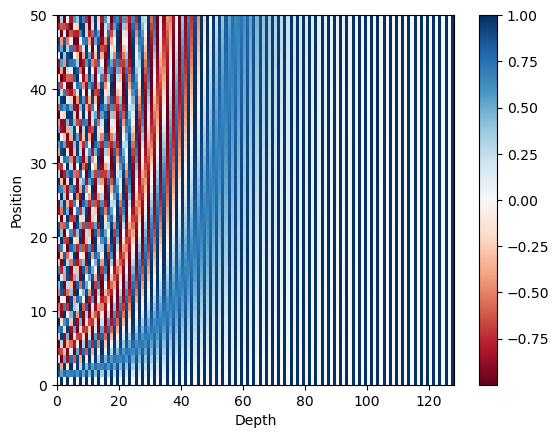

In [41]:
# 예시 

sample_pos_encoding = get_sinusoid_encoding_table(50, 128)

plt.pcolormesh(sample_pos_encoding._numpy()[0], cmap="RdBu")
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [42]:
""" attention pad mask """
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size , 1, 1, key의 문장 길이)
    return seq[:, tf.newaxis , tf.newaxis , :]

In [43]:
""" attention decoder mask """
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [44]:
""" scale dot product attention """
def ScaledDotProductAttention(query, key, value, mask) :
    """
    query , key, value의 leading dimension은 동일해야 함
    key, value에는 끝에서 두 번째 차원이 있어야 함(예: seq_len_k = seq_len_v)
    MASK는 유형에 따라 모양이 다름

    Args : 
        query : query.shape == (batch_size, n_heads, seq_len_q, depth)
        key   : key.shape   == (batch_size, n_heads, seq_len_k, depth)
        value : value.shape == (batch_size, n_heads , seq_len_v, depth_v)
        mask  : mask.shape == (batch_size, n_heads, seq_len_q, seq_len_k)  # Default to None

    return :
        output , attention_weights
    """
    # transpose_b=True : 곱하기 전에 트랜스포즈(전치)
    matmul_pk = tf.matmul(query, key, transpose_b=True )
    #(..., seq_len_q, seq_len_k)

    # scale matmul_qk 
    dk = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_pk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor
    if mask is not None :
        scaled_attention_logits += (mask * -1e9)
    
    # softmax 정규화
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis= -1)

    output = tf.matmul(attention_weights, value) # (..., seq_len_q, depth_v)

    return output, attention_weights



In [45]:
""" Multi head attention """
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, hid_dim, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.n_heads = n_heads
        assert hid_dim % self.n_heads == 0
        self.hid_dim = hid_dim

        self.depth = int(hid_dim / self.n_heads)

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.q_linear = tf.keras.layers.Dense(hid_dim)
        self.k_linear = tf.keras.layers.Dense(hid_dim)
        self.v_linear = tf.keras.layers.Dense(hid_dim)

        # WO에 해당하는 밀집층 정의
        self.out = tf.keras.layers.Dense(hid_dim)

    def split_heads(self, inputs, batch_size) :
        """ 
        마지막 차원을 변경 (n_heads, depth)
        """
        inputs = tf.reshape(inputs, (batch_size, -1, self.n_heads, self.depth))
        return tf.transpose(inputs, perm=[0,2,1,3])
    
    def call(self, value, key, query, mask):
        batch_size = tf.shape(query)[0]

        # step1 : WQ, WK, WV에 해당하는 밀집층 지나기
        query = self.q_linear(query)
        key = self.k_linear(key)
        value = self.v_linear(value)

        # step2 : 헤드 나누기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # step3 : 스케일드 닷 프로덕트 어텐션
        scaled_attention, attention_weights = ScaledDotProductAttention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # step4 : 헤드 연결
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.hid_dim))

        # step5 : WO 해당하는 밀집층 지나기
        outputs = self.out(concat_attention)

        return outputs, attention_weights


In [46]:
""" feed forward """
class PositionwiseFeedforwardLayer(tf.keras.layers.Layer):
    def __init__(self, hid_dim, pf_dim):
        super(PositionwiseFeedforwardLayer, self).__init__()
        self.linear_1 = tf.keras.layers.Dense(pf_dim, activation='relu')
        self.linear_2 = tf.keras.layers.Dense(hid_dim)

    def forword(self, attention):
        output = self.linear_1(attention)
        output = self.linear_2(output)
        return output

In [47]:
""" decoder layer """
class DecoderLayer(tf.keras.layers.Layer) :
    def __init__(self, pf_dim, hid_dim, n_heads, dropout):
        super(DecoderLayer, self).__init__()

        self.attn = MultiHeadAttentionLayer(hid_dim, n_heads)

        self.ffn = PositionwiseFeedforwardLayer(hid_dim, pf_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout)

        self.dropout3 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training, look_ahead_mask) :
        attention1, attn_weights_block1 = self.attn(inputs, inputs, inputs, look_ahead_mask)
        attention1 = self.dropout1(attention1, training= training)
        attention1 = self.layernorm1(inputs + attention1)

        ffn_outputs = self.ffn(attention1)
        ffn_outputs = self.dropout3(ffn_outputs, training = training)
        ffn_outputs = self.layernorm3(attention1 + ffn_outputs)

        return ffn_outputs , attn_weights_block1



In [48]:
""" decoder """
class Decoder(tf.keras.layers.Layer):
    def __init__(self, n_dec_vocab, n_layers, pf_dim, hid_dim, n_heads, maximum_position_encoding, dropout) :
        super(Decoder, self).__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = tf.keras.layers.Embedding(n_dec_vocab, hid_dim)
        self.pos_encoding = get_sinusoid_encoding_table(maximum_position_encoding, hid_dim)

        self.dec_layers = [DecoderLayer(pf_dim, hid_dim, n_heads, dropout) for _ in range(n_layers)]

        # 수정
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, dec_input, training, look_ahead_mask):
        seq_len = tf.shape(dec_input)[1]
        attention_weights = {}

        emb = self.embedding(dec_input)
        emb*= tf.math.sqrt(tf.cast(self.hid_dim, tf.float32))
        emb+= self.pos_encoding[:, :seq_len, :]

        output = self.dropout(emb , training= training)

        for i in range(self.n_layers):
            output, block1 = self.dec_layers[i](output, training, look_ahead_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1

        return output, attention_weights

In [49]:
def create_masks(tar) :
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return look_ahead_mask

In [50]:
# Model 정의
""" transformer """
class GPT2(tf.keras.Model) :
    def __init__(self, n_enc_vocab, n_dec_vocab, n_layers, pf_dim, hid_dim, n_heads, pe_input, pe_target, dropout):
        super(GPT2, self).__init__()

        self.decoder = Decoder(n_dec_vocab,
                               n_layers, pf_dim, hid_dim, n_heads, 
                               pe_target, dropout)
        
        self.fin_output = tf.keras.layers.Dense(n_dec_vocab)

    def call(self, inp, training, look_ahead_mask) :
        dec_output, attention_weights = self.decoder(inp, training, look_ahead_mask)

        final_output = self.fin_output(dec_output)

        return final_output, attention_weights


In [51]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [52]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


In [53]:
learning_rate = 0.01 
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon=1e-9)

In [54]:
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)


In [55]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [56]:
""" Training and checkpointing """

model = GPT2(
    n_enc_vocab=n_enc_vocab , 
    n_dec_vocab=n_dec_vocab , 
    n_layers=n_layers , 
    pf_dim=pf_dim , 
    hid_dim=hid_dim, 
    n_heads=n_heads,
    pe_input= 512 ,
    pe_target= 512 , 
    dropout= dropout
)

In [57]:
checkpoint_path = "./checkpoints"

ckpt = tf.train.Checkpoint(model=model, optimizer= optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint :
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Lastest checkpoint restored!!")
# import logging
# logging.DEBUG('')

In [58]:
@tf.function
def train_step(inp, tar):
    combined_mask = create_masks(inp)

    with tf.GradientTape() as tape :
        predictions, _ = model(inp, True, combined_mask)
        loss = loss_function(tar, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar, predictions))


In [59]:
for epoch in range(N_EPRCHS):
    train_loss.reset_state()

    with tqdm_notebook(total=len(datasets), desc = f'Train {epoch+1}') as pbar :
        for (batch, (inp, tar)) in enumerate(datasets):
            train_step(inp, tar)

            pbar.update(1)
            pbar.set_postfix_str(f"Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

ckpt_save_path = ckpt_manager.save()
print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

C:\Users\user\AppData\Local\Temp\ipykernel_27444\142244732.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(datasets), desc = f'Train {epoch+1}') as pbar :


Train 1:   0%|          | 0/32 [00:00<?, ?it/s]

AttributeError: in user code:

    File "C:\Users\user\AppData\Local\Temp\ipykernel_27444\3924528485.py", line 6, in train_step  *
        predictions, _ = model(inp, True, combined_mask)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\AppData\Local\Temp\__autograph_generated_filecwljnz7p.py", line 10, in tf__call
        (dec_output, attention_weights) = ag__.converted_call(ag__.ld(self).decoder, (ag__.ld(inp), ag__.ld(training), ag__.ld(look_ahead_mask)), None, fscope)
    File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileqv8hqgw_.py", line 33, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(self).n_layers,), None, fscope), None, loop_body, get_state, set_state, ('output',), {'iterate_names': 'i'})
    File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileqv8hqgw_.py", line 29, in loop_body
        (output, block1) = ag__.converted_call(ag__.ld(self).dec_layers[ag__.ld(i)], (ag__.ld(output), ag__.ld(training), ag__.ld(look_ahead_mask)), None, fscope)
    File "C:\Users\user\AppData\Local\Temp\__autograph_generated_files64w0xxv.py", line 10, in tf__call
        (attention1, attn_weights_block1) = ag__.converted_call(ag__.ld(self).attn, (ag__.ld(inputs), ag__.ld(inputs), ag__.ld(inputs), ag__.ld(look_ahead_mask)), None, fscope)
    File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileoogvb3ty.py", line 17, in tf__call
        (scaled_attention, attention_weights) = ag__.converted_call(ag__.ld(ScaledDotProductAttention), (ag__.ld(query), ag__.ld(key), ag__.ld(value), ag__.ld(mask)), None, fscope)
    File "C:\Users\user\AppData\Local\Temp\__autograph_generated_file1at9d0_i.py", line 25, in tf__ScaledDotProductAttention
        dk = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(tf).shape, (ag__.ld(key),), None, fscope)[-1].tf.float32,), None, fscope)

    AttributeError: Exception encountered when calling layer 'gpt2' (type GPT2).
    
    in user code:
    
        File "C:\Users\user\AppData\Local\Temp\ipykernel_27444\4084406977.py", line 14, in call  *
            dec_output, attention_weights = self.decoder(inp, training, look_ahead_mask)
        File "c:\ProgramData\Anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileqv8hqgw_.py", line 33, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(self).n_layers,), None, fscope), None, loop_body, get_state, set_state, ('output',), {'iterate_names': 'i'})
        File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileqv8hqgw_.py", line 29, in loop_body
            (output, block1) = ag__.converted_call(ag__.ld(self).dec_layers[ag__.ld(i)], (ag__.ld(output), ag__.ld(training), ag__.ld(look_ahead_mask)), None, fscope)
        File "C:\Users\user\AppData\Local\Temp\__autograph_generated_files64w0xxv.py", line 10, in tf__call
            (attention1, attn_weights_block1) = ag__.converted_call(ag__.ld(self).attn, (ag__.ld(inputs), ag__.ld(inputs), ag__.ld(inputs), ag__.ld(look_ahead_mask)), None, fscope)
        File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileoogvb3ty.py", line 17, in tf__call
            (scaled_attention, attention_weights) = ag__.converted_call(ag__.ld(ScaledDotProductAttention), (ag__.ld(query), ag__.ld(key), ag__.ld(value), ag__.ld(mask)), None, fscope)
        File "C:\Users\user\AppData\Local\Temp\__autograph_generated_file1at9d0_i.py", line 25, in tf__ScaledDotProductAttention
            dk = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(tf).shape, (ag__.ld(key),), None, fscope)[-1].tf.float32,), None, fscope)
    
        AttributeError: Exception encountered when calling layer 'decoder' (type Decoder).
        
        in user code:
        
            File "C:\Users\user\AppData\Local\Temp\ipykernel_27444\3466053320.py", line 27, in call  *
                output, block1 = self.dec_layers[i](output, training, look_ahead_mask)
            File "c:\ProgramData\Anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "C:\Users\user\AppData\Local\Temp\__autograph_generated_files64w0xxv.py", line 10, in tf__call
                (attention1, attn_weights_block1) = ag__.converted_call(ag__.ld(self).attn, (ag__.ld(inputs), ag__.ld(inputs), ag__.ld(inputs), ag__.ld(look_ahead_mask)), None, fscope)
            File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileoogvb3ty.py", line 17, in tf__call
                (scaled_attention, attention_weights) = ag__.converted_call(ag__.ld(ScaledDotProductAttention), (ag__.ld(query), ag__.ld(key), ag__.ld(value), ag__.ld(mask)), None, fscope)
            File "C:\Users\user\AppData\Local\Temp\__autograph_generated_file1at9d0_i.py", line 25, in tf__ScaledDotProductAttention
                dk = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(tf).shape, (ag__.ld(key),), None, fscope)[-1].tf.float32,), None, fscope)
        
            AttributeError: Exception encountered when calling layer 'decoder_layer' (type DecoderLayer).
            
            in user code:
            
                File "C:\Users\user\AppData\Local\Temp\ipykernel_27444\3315783466.py", line 19, in call  *
                    attention1, attn_weights_block1 = self.attn(inputs, inputs, inputs, look_ahead_mask)
                File "c:\ProgramData\Anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "C:\Users\user\AppData\Local\Temp\__autograph_generated_fileoogvb3ty.py", line 17, in tf__call
                    (scaled_attention, attention_weights) = ag__.converted_call(ag__.ld(ScaledDotProductAttention), (ag__.ld(query), ag__.ld(key), ag__.ld(value), ag__.ld(mask)), None, fscope)
                File "C:\Users\user\AppData\Local\Temp\__autograph_generated_file1at9d0_i.py", line 25, in tf__ScaledDotProductAttention
                    dk = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(tf).shape, (ag__.ld(key),), None, fscope)[-1].tf.float32,), None, fscope)
            
                AttributeError: Exception encountered when calling layer 'multi_head_attention_layer' (type MultiHeadAttentionLayer).
                
                in user code:
                
                    File "C:\Users\user\AppData\Local\Temp\ipykernel_27444\4203886506.py", line 40, in call  *
                        scaled_attention, attention_weights = ScaledDotProductAttention(query, key, value, mask)
                    File "C:\Users\user\AppData\Local\Temp\ipykernel_27444\580998220.py", line 22, in ScaledDotProductAttention  *
                        dk = tf.cast(tf.shape(key)[-1]. tf.float32)
                
                    AttributeError: 'Tensor' object has no attribute 'tf'
                
                
                Call arguments received by layer 'multi_head_attention_layer' (type MultiHeadAttentionLayer):
                  • value=tf.Tensor(shape=(256, 61, 128), dtype=float32)
                  • key=tf.Tensor(shape=(256, 61, 128), dtype=float32)
                  • query=tf.Tensor(shape=(256, 61, 128), dtype=float32)
                  • mask=tf.Tensor(shape=(256, 1, 61, 61), dtype=float32)
            
            
            Call arguments received by layer 'decoder_layer' (type DecoderLayer):
              • inputs=tf.Tensor(shape=(256, 61, 128), dtype=float32)
              • training=True
              • look_ahead_mask=tf.Tensor(shape=(256, 1, 61, 61), dtype=float32)
        
        
        Call arguments received by layer 'decoder' (type Decoder):
          • dec_input=tf.Tensor(shape=(256, 61), dtype=int64)
          • training=True
          • look_ahead_mask=tf.Tensor(shape=(256, 1, 61, 61), dtype=float32)
    
    
    Call arguments received by layer 'gpt2' (type GPT2):
      • inp=tf.Tensor(shape=(256, 61), dtype=int64)
      • training=True
      • look_ahead_mask=tf.Tensor(shape=(256, 1, 61, 61), dtype=float32)
